## Importanto datos y librerias

## Importacion y tratamiento de los datos

In [1]:
# Carga de librerías y lectura del archivo que contiene los datos

import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from pyod.models.iforest import IForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt"
cols = ["B","G","R","y"]

data = pd.read_csv(url, sep=r"\s+", header=None, names=cols, engine="python")

print(data.head(),data.shape)

    B   G    R  y
0  74  85  123  1
1  73  84  122  1
2  72  83  121  1
3  70  81  119  1
4  70  81  119  1 (245057, 4)


In [3]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245057 entries, 0 to 245056
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   B       245057 non-null  int64
 1   G       245057 non-null  int64
 2   R       245057 non-null  int64
 3   y       245057 non-null  int64
dtypes: int64(4)
memory usage: 7.5 MB


In [5]:
data.describe()

,B,G,R,y
count,245057.000000,245057.000000,245057.000000,245057.000000
mean,125.065446,132.507327,123.177151,1.792461
std,62.255653,59.941197,72.562165,0.405546
min,0.000000,0.000000,0.000000,1.000000
25%,68.000000,87.000000,70.000000,2.000000
50%,139.000000,153.000000,128.000000,2.000000
75%,176.000000,177.000000,164.000000,2.000000
max,255.000000,255.000000,255.000000,2.000000


In [6]:
X_num = data[["B","G","R"]]
print(type(X_num))

<class 'pandas.core.frame.DataFrame'>


C:\Users\workw\AppData\Local\Temp\ipykernel_26100\1230482870.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_boxplot, labels=labels, showfliers=True)


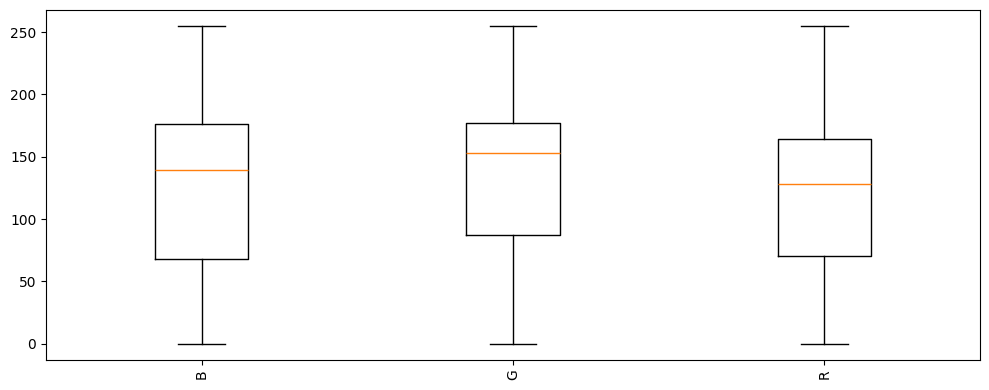

In [7]:
plt.figure(figsize=(10, 4))

# boxplot de todas las columnas (como tu imagen)
data_boxplot = []
labels = []
for col in X_num.columns:
    data_boxplot.append(X_num[col].dropna().values)
    labels.append(col)

plt.boxplot(data_boxplot, labels=labels, showfliers=True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
print(data["y"].value_counts())

y
2    194198
1     50859
Name: count, dtype: int64


In [9]:
# Detectar outliers y reemplazar con NaN
target2 = "y"  # ajusta si tu columna se llama distinto

# 1) Solo variables numéricas (sin el target)
X2 = data.drop(columns=[target2], errors="ignore")

# 2) Entrenar detector de outliers
# contamination = proporción esperada de outliers (ajusta: 0.05, 0.1, etc.)
clf = IForest(contamination=0.05, random_state=42)
clf.fit(X2)

# 3) Etiquetas: 1 = outlier, 0 = normal
is_outlier = clf.labels_.astype(bool)

# 4) Reemplazar con NaN (en las columnas numéricas, para las filas outliers)
data = data.copy()
num_cols = X2.columns
data.loc[X2.index[is_outlier], num_cols] = np.nan

print("Outliers detectados:", is_outlier.sum())
data.head()

Outliers detectados: 12253


,B,G,R,y
0,74.0,85.0,123.0,1
1,73.0,84.0,122.0,1
2,72.0,83.0,121.0,1
3,70.0,81.0,119.0,1
4,70.0,81.0,119.0,1


In [10]:
col_nulos = data.drop(columns=["y"], errors="ignore")

resumen_nulos = (
    col_nulos.isnull()
    .sum()
    .reset_index()
)

resumen_nulos.columns = ["columnas", "nulos"]

total_filas = len(col_nulos)

resumen_nulos["% nulos"] = (resumen_nulos["nulos"] / total_filas * 100).round(2)

resumen_nulos


,columnas,nulos,% nulos
0,B,12253,5.0
1,G,12253,5.0
2,R,12253,5.0


In [11]:
# Copia del dataset
data_nonull = data.copy()

# Reemplazar NaN por la media (solo en columnas numéricas)
num_cols = data_nonull.select_dtypes(include="number").columns
data3_nonull=data_nonull.dropna()


Lo que se hizo es que se elimino los outliers convertidos en NaN

In [12]:
# Se normalizan los tres atributos seleccionados
data['B'] = preprocessing.scale(data['B'])
data['G'] = preprocessing.scale(data['G'])
data['R'] = preprocessing.scale(data['R'])
data.head()

,B,G,R,y
0,-0.881595,-0.841491,0.040474,1
1,-0.898712,-0.859148,0.026326,1
2,-0.915829,-0.876805,0.012179,1
3,-0.950062,-0.912120,-0.016117,1
4,-0.950062,-0.912120,-0.016117,1


## Matriz de correlacion

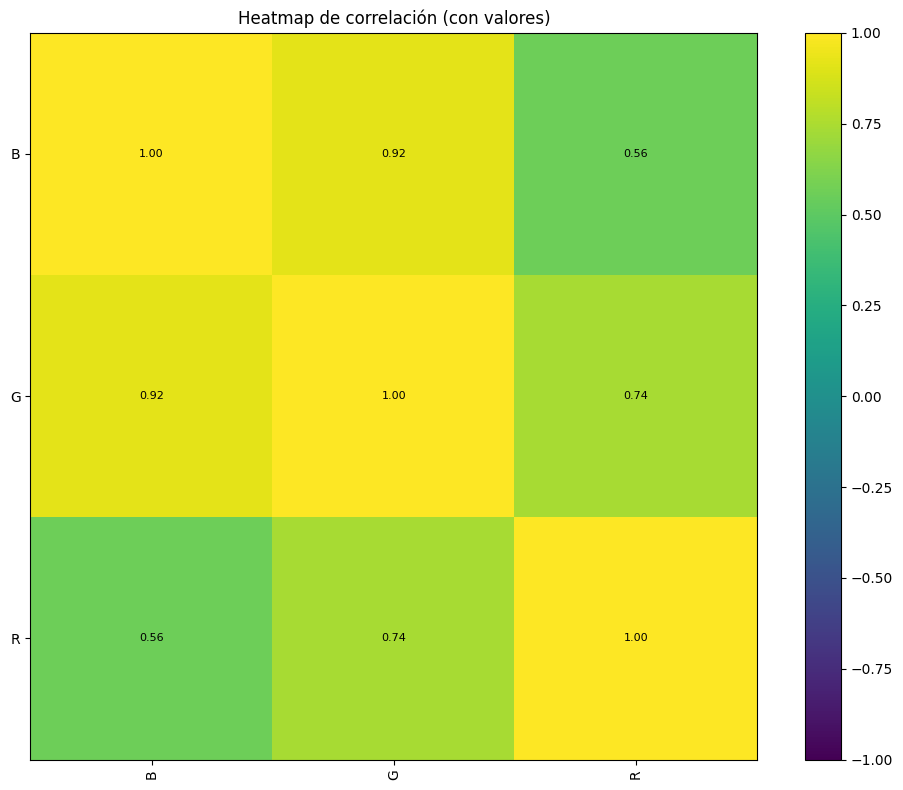

In [13]:
# solo numéricas y excluyendo la columna objetivo
X_num = data_nonull.drop(columns=["y"], errors="ignore")
corr = X_num.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr, vmin=-1, vmax=1)
fig.colorbar(im, ax=ax)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

# escribir valores en cada celda
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha="center", va="center", fontsize=8, color="black")

ax.set_title("Heatmap de correlación (con valores)")
plt.tight_layout()
plt.show()

In [14]:
# 1) Dejar solo filas completas en B,G,R (y opcionalmente y también)
cols_feat = ["B","G","R"]
data_nonull = data.dropna(subset=cols_feat).copy()

# (opcional) asegurar tipos
data_nonull[cols_feat + ["y"]] = data_nonull[cols_feat + ["y"]].apply(pd.to_numeric, errors="coerce")
data_nonull = data_nonull.dropna(subset=cols_feat + ["y"]).copy()

# 2) Definir X e y
target = "y"
X = data_nonull[cols_feat]
y = data_nonull[target]

def score_with_drop(col_to_drop=None):
    X_use = X.drop(columns=[col_to_drop], errors="ignore") if col_to_drop else X
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=3000))
    ])
    return cross_val_score(model, X_use, y, cv=5, scoring="f1_macro").mean()

print("Sin eliminar:", f"{score_with_drop(None):.4f}")
print("Eliminando B:", f"{score_with_drop('B'):.4f}")
print("Eliminando G:", f"{score_with_drop('G'):.4f}")
print("Eliminando R:", f"{score_with_drop('R'):.4f}")


Sin eliminar: 0.9260
Eliminando B: 0.9159
Eliminando G: 0.9317
Eliminando R: 0.8329


A partir del codigo anterior se determina que el f1 tiene mayor valor cuando retiramos la variable G, por lo que se procede a modelar

In [15]:
data=data_nonull
data = data.drop(columns=["G"], axis=1)

In [16]:
data['y'].value_counts()


y
2    181961
1     50843
Name: count, dtype: int64

In [17]:
# Se hace balanceo de clases eliminando ejemplos de la clase mayoritaria
g = data.groupby("y")
dataBal = (g.apply(lambda x: x.sample(g.size().min(), random_state=42))
             .reset_index(drop=True))

data=dataBal

In [18]:
dataBal['y'].value_counts()

y
1    50843
2    50843
Name: count, dtype: int64

## Modelado

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    dataBal.drop('y', axis=1),
    dataBal['y'],
    test_size=0.30,      # 40% prueba -> 60% entrenamiento
    random_state=42,
    stratify=dataBal['y']  # mantiene la proporción de clases
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(71180, 2) (71180,)
(30506, 2) (30506,)


In [20]:
# Entrenamiento del modelo de clasificación por regresión logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logisticRegr = LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01, random_state=42)
logisticRegr.fit(X_train, y_train)


LogisticRegression(max_iter=500, random_state=42, tol=0.01)

In [21]:
# Aplicación del modelo construido a los datos de test
predictions = logisticRegr.predict(X_test)
predictions

array([1, 1, 1, ..., 2, 1, 1], dtype=int64)

In [22]:
# Cálculo del accuracy para evaluar el desempeño del modelo sobre los datos de test
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions)

0.9772503769750213

## 10 FOLD

### Preparacion X,Y

In [23]:
# features y target (ajusta si tus columnas cambian)
X = data[["B","R"]].copy()
y = data["y"].copy()

# Asegurar numéricos
X = X.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(y, errors="coerce")

# Quitar filas con NaN en X o y
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask]
y = y.loc[mask].astype(int)

# Convertir y a 0/1 si viene como 1/2
if set(np.unique(y)) == {1, 2}:
    y = (y == 2).astype(int)  # 1->0, 2->1 (ajusta si tu "positivo" es 1)

# Modelo
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, solver="lbfgs"))
])

### Funcion para metricas + matriz de confusion

In [24]:
def metrics_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn) if (tp + fn) else 0.0            # Sensitivity
    spec = tn / (tn + fp) if (tn + fp) else 0.0              # Specificity
    prec = tp / (tp + fp) if (tp + fp) else 0.0              # Precision
    f1 = 2 * prec * recall / (prec + recall) if (prec + recall) else 0.0
    return {"accuracy": acc, "recall": recall, "specificity": spec, "precision": prec, "f1": f1}


### N-folds validation con N=10 (StratifiedKFold)

In [25]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cms = []
rows = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    m = clone(model)
    m.fit(X_train, y_train)
    pred = m.predict(X_test)

    cm = confusion_matrix(y_test, pred, labels=[0,1])
    cms.append(cm)
    rows.append(metrics_from_cm(cm))

cm_10fold = np.sum(cms, axis=0)
metrics_10fold = pd.DataFrame(rows).mean()

print("=== 10-Fold CV (N=10) ===")
print("Matriz de confusión (acumulada):\n", cm_10fold)
print("\nMétricas promedio:")
print(metrics_10fold)

=== 10-Fold CV (N=10) ===
Matriz de confusión (acumulada):
 [[50585   258]
 [ 2260 48583]]

Métricas promedio:
accuracy       0.975238
recall         0.955550
specificity    0.994926
precision      0.994980
f1             0.974794
dtype: float64


### Random subsampling 70/30 con 10 repeticiones

In [26]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.30, random_state=42)

cms = []
rows = []

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    m = clone(model)
    m.fit(X_train, y_train)
    pred = m.predict(X_test)

    cm = confusion_matrix(y_test, pred, labels=[0,1])
    cms.append(cm)
    rows.append(metrics_from_cm(cm))

cm_sub = np.sum(cms, axis=0)
metrics_sub = pd.DataFrame(rows).mean()


print("=== Random Subsampling 70/30 (10 repeticiones) ===")
print("Matriz de confusión (acumulada):\n", cm_sub)

print("\nMétricas promedio:")
print(metrics_sub)


=== Random Subsampling 70/30 (10 repeticiones) ===
Matriz de confusión (acumulada):
 [[152530      0]
 [  6805 145725]]

Métricas promedio:
accuracy       0.977693
recall         0.955386
specificity    1.000000
precision      1.000000
f1             0.977184
dtype: float64


## Analisis de resultados

# Se evaluó un modelo de Regresión Logística para clasificación binaria usando dos
# esquemas de validación solicitados:
#
# (1) Validación cruzada 10-Fold (N=10):
#     - Matriz de confusión acumulada: [[50585,  258],
#                                       [ 2260, 48583]]
#     - Métricas promedio: Accuracy≈0.975, Recall≈0.956, Specificity≈0.995,
#       Precision≈0.995, F1≈0.975.
#
#     Interpretación:
#     - El modelo presenta un desempeño alto y equilibrado.
#     - La especificidad es muy alta (~0.995), lo que indica que clasifica muy bien
#       la clase negativa (pocos falsos positivos: 258).
#     - El recall/sensibilidad (~0.956) es ligeramente menor, lo que indica que aún
#       existen falsos negativos (2260). En problemas donde perder positivos es
#       costoso, esto sería el principal punto a mejorar (por ejemplo ajustando umbral
#       o usando class_weight).
#
# (2) Random Subsampling 70/30 con 10 repeticiones:
#     - Matriz de confusión acumulada: [[152530,      0],
#                                       [  6805, 145725]]
#     - Métricas promedio: Accuracy≈0.978, Recall≈0.955, Specificity=1.000,
#       Precision=1.000, F1≈0.977.
#
#     Interpretación:
#     - El desempeño promedio es similar o ligeramente superior al 10-Fold.
#     - Sin embargo, al sumar matrices de múltiples particiones 70/30, es posible que
#       aparezcan métricas “perfectas” (por ejemplo Specificity=1.0 o Precision=1.0),
#       lo cual puede deberse a la variabilidad de los splits y al fuerte desbalance:
#       en algunos cortes, el modelo puede no generar falsos positivos.
#
# Comparación y “mejor” esquema para este caso:
# - Ambos métodos muestran resultados consistentes (Accuracy y F1 ~ 0.97–0.98).
# - 10-Fold CV suele ser preferible para reportes académicos porque:
#   (a) usa todas las observaciones como test exactamente una vez,
#   (b) reduce la dependencia de un conjunto de prueba particular,
#   (c) produce una estimación más estable y comparable entre modelos.
# - Random Subsampling 70/30 (10 repeticiones) es útil para observar variabilidad
#   bajo particiones aleatorias y se aproxima a la práctica de “varios train/test”.
#
# Conclusión:
# - El modelo de Regresión Logística funciona muy bien con estas variables y muestra
#   alta capacidad de generalización.
# - Si el objetivo es un reporte más robusto y estándar, se recomienda presentar como
#   principal el esquema 10-Fold CV y usar el subsampling 70/30 como validación
#   complementaria.
# =============================================================================
